# Recommendations with IBM

This Notebook recommendations methodologies on actual data from the IBM Watson Studio platform. The recommendations method can be exploited for similar projects. 

<img src="watson_logo.png" width="700"/>


## Table of Contents

* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Rank Based Recommendations](#Rank)
* [User-User Based Collaborative Filtering](#User-User)
* [Content Based Recommendations](#Content-Recs)
* [Matrix Factorization](#Matrix-Fact)
* [Extras & Concluding](#conclusions)

In [6]:
# Importing the required libraries
import numpy as np
import pandas as pd
import project_tests as t
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('abc')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/NS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/NS/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package abc to /Users/NS/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package punkt to /Users/NS/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Loading user-intraction & article-description data
df = pd.read_csv('Data/user-item-interactions.csv')
df_content = pd.read_csv('Data/articles_community.csv')

In [8]:
# Exploring a glimps of the dataframe 
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [9]:
# Exploring a glimps of the dataframe 
df_content.head()

,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [10]:
# Removing unneccsary columns 
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [11]:
# Verifing the removals 
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [12]:
# Verifing the removals 
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [13]:
df_number = df.groupby(['email']).size().reset_index(name='article_counts')
df_number = df_number.sort_values(by=['article_counts'], ascending=False)
df_number

,email,article_counts
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
...,...,...
565,1b520f0f65c0aee52d4235f92fb2de58fa966635,1
2481,7a67e4a2902a20062e1f2a6835b6e099b34b4f6c,1
4003,c4b7e639e91b1d18e5b9c000f0ad3354888fcdde,1
2483,7a7fb282789944665ffc1cddee5ddbdbd7ca9f64,1


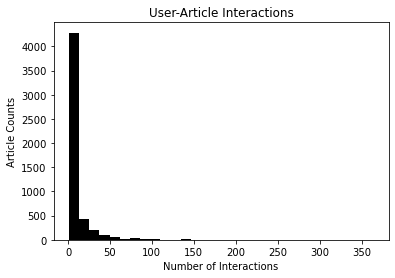

In [14]:
x = df_number['article_counts']
plt.hist(x, bins=30, color='black');
plt.xlabel('Number of Interactions');
plt.ylabel('Article Counts')
plt.title('User-Article Interactions');
plt.show()

In [15]:
# The median and maximum number of user_article interactios 
median_val = int(df_number.median())
print("50% of individuals interact with {} number of articles or fewer.".format(median_val)) 

max_views_by_user = df_number['article_counts'].max()
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [16]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [17]:
# Identifying duplicate articles
df_content.duplicated(['article_id']).sum()

5

In [18]:
df_cont_dup = np.where(df_content.duplicated(['article_id']))
df_cont_dup

(array([365, 692, 761, 970, 971]),)

In [19]:
# Checking if there are any article ids which are duplicates
df_cont_dup = np.where(df_content.duplicated(['article_id']))

# Display the dataframe of duplicated ids
for id in df_cont_dup[0]:
    display(df_content[df_content['article_id'] == id])

,doc_body,doc_description,doc_full_name,doc_status,article_id
366,GO SERVERLESS WITH APEX AND COMPOSE'S MONGODB\...,While AWS's Lambda service treats each functio...,Go Serverless with Apex and Compose's MongoDB,Live,365


,doc_body,doc_description,doc_full_name,doc_status,article_id
694,Skip to content * Unix\r\n * R\r\n\r\n15 PAGE ...,"For Beginners in R, here is a 15 page example ...",15 Page Tutorial for R,Live,692


,doc_body,doc_description,doc_full_name,doc_status,article_id
764,Elvis Dohmatob Home Blog Publications Photos C...,"In this post, I’ll demo variational auto-encod...","Variational auto-encoder for ""Frey faces"" usin...",Live,761


,doc_body,doc_description,doc_full_name,doc_status,article_id
975,Compose The Compose logo Articles Sign in Free...,"In this third article in our the series, we'll...",Launching RESTHeart into Production,Live,970


,doc_body,doc_description,doc_full_name,doc_status,article_id
976,Cloudant allows custom Javascript to be run se...,Cloudant allows custom Javascript to be run se...,Defensive coding in Map/Index functions,Live,971


In [20]:
# Removing duplicates on article ids
df_cont_Dup_drop = df_content.drop_duplicates(subset='article_id', keep='first')
df_cont_Dup_drop.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [21]:
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

In [22]:
df.groupby(['article_id']).count().sort_values('title', ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [23]:
df.groupby(['email']).count().head()

,article_id,title
email,,
0000b6387a0366322d7fbfc6434af145adf7fed1,13,13
001055fc0bb67f71e8fa17002342b256a30254cd,4,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6,6
001fc95b90da5c3cb12c501d201a915e4f093290,2,2


In [24]:
print(df.shape, df_cont_Dup_drop.shape)

(45993, 3) (1051, 5)


In [25]:
unique_articles = df.nunique()
unique_articles

article_id     714
title          714
email         5148
dtype: int64

In [26]:
# The number of unique articles that have at least one interaction
unique_articles = df.nunique()['article_id'] 

# The number of unique articles on the IBM platform
total_articles = df_cont_Dup_drop.shape[0] 

# The number of unique users
unique_users = df.nunique()['email'] 

# The number of user-article interactions
user_article_interactions = df.shape[0] 


print("The number of unique articles that have at least one interaction is {}.".format(unique_articles))
print("The number of unique articles on the IBM platform is {}.".format(total_articles))
print("The number of unique users is {}.".format(unique_users))
print("The number of user-article interactions is {}.".format(user_article_interactions))

The number of unique articles that have at least one interaction is 714.
The number of unique articles on the IBM platform is 1051.
The number of unique users is 5148.
The number of user-article interactions is 45993.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [27]:
# Checking the most viewed article and its viewing counts
df_view_most = df.groupby(['article_id']).count()
df_view_most['email'].max()
df_view_most.loc[df_view_most['email'] == df_view_most['email'].max()]

,title,email
article_id,,
1429.0,937,937


In [28]:
# The most viewed article in the dataset 
most_viewed_article_id = "1429.0" 

# The most viewed article in the dataset was viewed how many times?
max_views = 937 

In [29]:
# Mapping the user email to a user_id column and removing the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [30]:
df.to_csv(r'./dftest.csv',index=False)

In [31]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Rank-Based Recommendations</a>

In earlier stages, we analysed users' intractions with articles with no considerations of their ratings and their intrests. Therefore the popularity of an article was based on the number of intractions made by the users.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [32]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [33]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Use size() to get the number of elements in groupby to extract the top articles
    top_articles = df.groupby(['article_id', 'title']).size()\
                        .reset_index(name='counts').sort_values('counts', ascending=False)[:n].title.tolist()
    
    # Return the top article titles from df (not df_content)
    return top_articles

In [34]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Use count() is acting similar to size() but returns series
    top_articles = df.groupby("article_id").count()["title"].sort_values(ascending=False).index[:n].astype('str')
    
    # Return the top article ids
    return top_articles 

In [35]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
Index(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
       '1170.0', '1162.0', '1304.0'],
      dtype='object', name='article_id')


In [36]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

In [37]:
# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">User-User Based Collaborative Filtering</a>


`1.` The function below reshapes the **df** dataframe so that users indicate the rows and columns show the articles.  

* Each **user** should only appear once in each **row**.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero,0, where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [40]:
# Creating user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # unstack the user-item interaction dataframe
    user_item = df.drop_duplicates().groupby(['user_id', 'article_id']).size().unstack()
    
    # fill missing values with 0
    user_item = user_item.fillna(0)
    
    # convert int
    user_item = user_item.astype('int')
    
    # return the user_item matrix
    return user_item  

user_item = create_user_item_matrix(df)

In [42]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` As the results for each user here are binary, the decision is to perform similarity as the dot product of two users. Therefore, function below takes a **user_id** and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided **user_id**, since each user is similar to itself.  

Use the tests to test your function.

In [43]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user and Sort by similarity
    user_similr = user_item.loc[user_id,:].dot(user_item.T).sort_values(ascending = False)

    # Create list of just the ids also Removing the own user's id
    most_similar_users = user_similr.loc[~(user_similr.index ==  user_id)].index.values.tolist()
     
    # return a list of the users in order from most to least similar    
    return most_similar_users 
        

In [44]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that the function will provide the most similar users to each user, this can be used to find articles that you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [94]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title'])
    
    # Return the article names associated with list of article ids
    return article_names

In [95]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get all articles for this user id
    user_idx = user_item.loc[user_id,:]
    
    # Get articles user interacted with
    article_ids = user_idx[user_idx == 1].index.values.astype('str').tolist()
    
    # Get article names 
    article_names = get_article_names(article_ids)
    
    # return the ids and names
    return article_ids, article_names 

In [96]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Get most similar users 
    most_similar_users = find_similar_users(user_id)
    
    # Get article ids 
    user_article_ids = set(get_user_articles(user_id)[0])
    recs = []
    
    # Create recommendations for this user
    for user_neighb in most_similar_users:
        neighb_article_ids = set(get_user_articles(user_neighb)[0])
        recs += list(set(neighb_article_ids) - set(user_article_ids))
        if len(recs) > m:
            break
    recs = recs[:m]
    
    # return your recommendations for this user_id  
    return recs   

In [97]:
# Check Results (Return 10 recommendations for user 1)
get_article_names(user_user_recs(1, 10)) 

['machine learning for the enterprise',
 'this week in data science (february 14, 2017)',
 'working with db2 warehouse on cloud in data science experience',
 'graph-based machine learning',
 'python machine learning: scikit-learn tutorial',
 'machine learning and the science of choosing',
 'build a python app on the streaming analytics service',
 'easy json loading and social sharing in dsx notebooks',
 'programmatic evaluation using watson conversation',
 'maximize oil company profits']

In [98]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Improving the consistency of the **user_user_recs** function.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [99]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user 
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Column names
    colName = ['neighbor_id', 'similarity', 'num_interactions'] 
    
    # Create dataframe to hold top users
    neighbors_df  = pd.DataFrame(columns= colName) 
    
    # Populate the dataframe
    for id in user_item.index.values:
        if id != user_id:
            neighbor_id = id
            
            # Get user to user similarity
            similarity = user_item[user_item.index == user_id].dot(user_item.loc[id].T).values[0]
            
            # Get number of interactions for user ot article
            num_interactions = user_item.loc[id].values.sum()
            neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
    
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    
    # Return the dataframe specified in the doc_string
    return neighbors_df 

In [100]:
# Testing the function
get_top_sorted_users(43)

,neighbor_id,similarity,num_interactions
3233,3233,7,8
23,23,6,135
3782,3782,6,135
58,58,5,70
98,98,5,97
...,...,...,...
5145,5145,0,5
5146,5146,0,7
5147,5147,0,1
5148,5148,0,1


In [142]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are satisfied
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get similar users
    neighbours = get_top_sorted_users(user_id)
    top_similar_users = neighbours['neighbor_id'].values.tolist()
    
    # recommended article Id's
    recs = [] 
    
    # Get articles read by the user
    user_article_ids = list(set(get_user_articles(user_id)[0]))
    
    # Generating recommendation list 
    for neighbour_id in top_similar_users:
        recs += df[df['user_id'] == neighbour_id]['article_id'].values.tolist()
    
    recs = list(set(recs))
    
    # Selecting articles not seen by User_id
    recs = [ x for x in recs if x not in user_article_ids]
    
    # Producing a dataframe from the recommendations
    recs_df = df[df.article_id.isin(recs)][['article_id', 'title']].drop_duplicates().head(m) 
    
    # To get the ids
    recs = recs_df['article_id'].values.tolist() 
    
    # To get titles
    rec_names = recs_df['title'].values.tolist() 
    
    return recs, rec_names

In [144]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1430.0, 1314.0, 1429.0, 1338.0, 1276.0, 1432.0, 593.0, 1185.0, 993.0, 14.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'visualize data with the matplotlib library', 'upload files to ibm data science experience using the command line', 'classify tumors with machine learning', 'configuring the apache spark sql context', 'got zip code data? prep it for analytics. – ibm watson data lab – medium']


`5.` Use the above functions to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [145]:
## Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id 

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id 

In [146]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

If new user is given, it would make sense to use **Rank Based Recommendations** and the `get_top_articles` function for making recommendations. As we do not hold information of the users, we would only select the most popular articles. On that ground, more information about the user will help to produce a combination 3 different recommendation techniques: **Rank**, **Content**, and **Collaborative**.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [147]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# Your recommendations here
new_user_recs = get_top_article_ids(10) 

In [148]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Content Based Recommendations (Supplementary)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, it can demonstrate advanced skills.

In [149]:
def tokenize(x):
    
    '''
    Tokenize a string into words. 
    
    Args:
        x(string): string to tokezine.
            
    Returns:
        (list): list of lemmatized words
    '''
    
    # Stop words - filtering unwanted words (ABC: collection of news from the Australian Broadcasting Commission)
    stop_words = (set(stopwords.words('english')) | set(nltk.corpus.abc.words()))
    
    # Breaking article titles into separate words
    tokens = word_tokenize(x) 
    
    # Bringig words to the base form of all their inflectional forms
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens=[]
    for token in tokens:
        
        # Removing each token from whitespace and punctuation, and convert to root word
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    # Filtering the list by stopwords and none-alphabet
    filtered = [word for word in clean_tokens if word not in stop_words and word.isalpha()]
    return filtered

In [153]:
# Testing the above function
tokenize(x='programmatic evaluation using watson conversation')

['programmatic', 'watson']

In [172]:
def make_content_recs(data_id, user_id=True, m=10, df=df):
    '''
    This recommender goes through each article title and nltk library to finds the most common words
    (related to content) throughout all the articles.
    
    The recommender will look at the sums of words in the title of each article 
    and based on the number of matches and popularity of an article.
       
    Args:
        data_id (str) - id of either user or article
        user_id (bool) - if true, make recs based on user
        m (int) - number of recommendations to give based on term
    Returns:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended   
    '''
    
    if user_id:
        user_id = data_id
        try:
            # Getting articles' IDs read by the user
            article_ids, _ = get_user_articles(user_id)
        
        # When user does not exist
        except KeyError: 
            print('User Doesn\'t Exist, Recommending Top Articles')
            recs = get_top_article_ids(m)
            return recs, get_article_names(recs)
    
    else:
        article_ids = data_id
        
    # Removing duplicates
    title_data = df.drop_duplicates(subset='article_id')  
    
    # Capturing article titles
    titles = title_data[title_data.article_id.isin(list(map(float, article_ids)))].title 
    
    # Tokenizing the words in each article titles, which are concatinated by a seperator
    title_words=[]
    tokenized = word_tokenize(titles.str.cat(sep=' '))
    
    # Adding each element of the list to another list
    title_words.extend(tokenized)
    
    # Find the highest occuring words 
    common_words = pd.value_counts(title_words).sort_values(ascending=False)[:10].index

    # Measure of similarity: count number of occurences of each common word in other article titles
    top_matches={}
    for word in common_words:
        
        # Occurences of each word in titles
        word_count = pd.Series(title_data.title.str.count(word).fillna(0)) 
        top_matches[word] = word_count
    
    # Most common words
    top_matches = pd.DataFrame(top_matches) 
    top_matches['top_matches'] = top_matches.sum(axis=1)
    top_matches['article_id'] = title_data.article_id.astype(float)
    
    # Getting most interacted with articles
    article_occurences = pd.DataFrame({'occurences':df.article_id.value_counts()})

    # Sorting matches by most popular articles
    top_matches = top_matches.merge(article_occurences, left_on='article_id', right_index=True)
    top_matches.sort_values(['top_matches', 'occurences'], ascending=False, inplace=True)    
    
    # Dropping already read articles
    recs_df = top_matches[~top_matches.article_id.isin(list(map(float, article_ids)))]
    
    # Getting recommendation IDs and Names
    recs = recs_df.article_id[:m].values.astype(str)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

- The **Content Based Recommender** iterates through past interacted articles. 
- The **NLTK** library finds the most occuring words in the title of each article. 
- Based upon the most occuring words, the recommender calculates the sums of their appearance in the title of each article. 
- Finally, sorting the number of matches in the titles, as well as the general popularity of the article the recommendation results can be drawn. 

In cases when the user has not read any article, content based recommendations is not applicable, hence the function returns back some most popular articles. 

There are always room for more precision, improvement and optimization for the function:

* The precisions could utilise **NLTK** corpus packages to filter out more article words. We only used a standard **NLTK** package. 
* The provision of the articles' content such as the main body could have improved our function.
* Using similar words semantically rather than syntactically to improve similarity.
* Disliking a specific content can be based on the subject not necessarily the structure or depth. **ML** algorithm could address such functionality.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [171]:
# make recommendations for a brand new user
make_content_recs('0.0', user_id=True)

User Doesn't Exist, Recommending Top Articles


(Index(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
        '1170.0', '1162.0', '1304.0'],
       dtype='object', name='article_id'),
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

In [173]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(['1427.0'], user_id=False)

(array(['254.0', '500.0', '1422.0', '437.0', '1319.0', '1419.0', '1172.0',
        '124.0', '1332.0', '812.0'], dtype='<U32'),
 ['apple, ibm add machine learning to partnership with watson-core ml coupling',
  'the difference between ai, machine learning, and deep learning?',
  'use r dataframes & ibm watson natural language understanding',
  'ibm watson machine learning: get started',
  'households by type of household, age and sex of head of household',
  'unmet need for family planning, spacing, percentage, worldwide, by country',
  'apache spark lab, part 3: machine learning',
  'python machine learning: scikit-learn tutorial',
  'intents & examples for ibm watson conversation',
  'machine learning exercises in python, part 1'])

## <a class="anchor" id="Matrix-Fact" style='color:purple '>Matrix Factorization</a> 


Here we use matrix factorization to make article recommendations to the users on the **IBM Watson Studio** platform. Matrix factorization is a class of **collaborative filtering** algorithms used in recommender systems. Its algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [181]:
# Quick look at the matrix
user_item_matrix = user_item
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use **Singular Value Decomposition** using **numpy** library on the user-item matrix.  Use the cell to perform **SVD**, and explain why this is different than in the lesson.

In [182]:
# Perform SVD on the User-Item Matrix Here
# Use the built-in to get the three matrices
u, s, vt =  np.linalg.svd(user_item_matrix)
print("Number of Nans in the users to item interactions matrix is: {}".format(np.isnan(user_item).sum().sum()))
print("Number of Nans in the users to latent features matrix is: {}".format(np.isnan(u).sum().sum()))
print("Number of Nans in the segma matrix is: {}".format(np.isnan(s).sum().sum()))
print("Number of Nans in the items to latent features matrix is: {}".format(np.isnan(vt).sum().sum()))

Number of Nans in the users to item interactions matrix is: 0
Number of Nans in the users to latent features matrix is: 0
Number of Nans in the segma matrix is: 0
Number of Nans in the items to latent features matrix is: 0


In [183]:
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

We can use **SVD** as there are no missing values (NANs) in our dataset. Also, in the classroom, our matrix had missing values which meant that we had to use **FunkSVD**.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

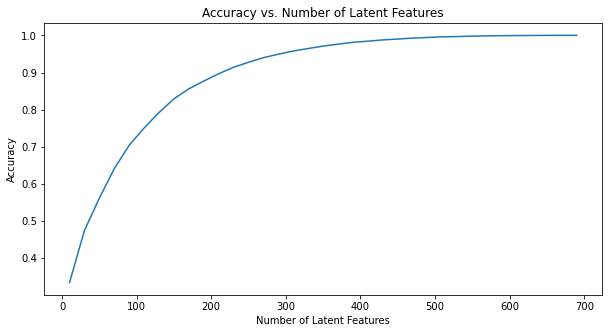

In [185]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    
    # Restructuring with k latent features
    u_new, s_new, vt_new = u[:, :k], np.diag(s[:k]), vt[:k, :]
    
    # Calculating dot products
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Calculating the error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.figure(figsize=(10,5))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [187]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Creating user item matrix for the train dataset
    user_item_train = create_user_item_matrix(df_train)
    
    # Creating user item matrix the test dataset
    user_item_test = create_user_item_matrix(df_test)
    
    # Getting the ids of the train and test datasets
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [188]:
# 682 users in test set
test_idx 

Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=682)

In [189]:
# 4487 users in training set
train_idx = user_item_train.index 
train_idx 

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
           dtype='int64', name='user_id', length=4487)

In [190]:
# of 682 users in test set, only 20 of them are in training set
test_idx.difference(train_idx) 

Int64Index([4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=662)

In [191]:
#574 movies in test set
test_arts 

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1432.0, 1433.0, 1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0,
              1441.0, 1443.0],
             dtype='float64', name='article_id', length=574)

In [192]:
#714 movies in train set
train_arts = user_item_train.columns 
train_arts

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', name='article_id', length=714)

In [193]:
# all articles in test set are in training set too
test_arts.difference(train_arts) 

Float64Index([], dtype='float64', name='article_id')

In [194]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now we can use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

We can use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below